# Distinguishing cats and dogs

In [32]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import urllib.request
import zipfile
import json

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input
from keras import applications
from keras import optimizers

In [33]:
%matplotlib inline

In [34]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [35]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13821737158217109110
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7341044532
locality {
  bus_id: 1
}
incarnation: 13442459508953182652
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Download the data

In [36]:
def download_file_if_not_existing(url, dest):
    if not os.path.isfile(dest):
        print("Downloading File")
        urllib.request.urlretrieve(url, dest)
        print("Unzipping file")
        zip = zipfile.ZipFile(dest)
        zip.extractall()
    print("Files ready")

In [38]:
!mkdir data
!mkdir data/test
!mkdir data/train

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/test’: File exists


Please manually download the file from the kaggle competition site and save them in the download folder.

In [46]:
!unzip ./data/test.zip -d ./data 
!unzip ./data/train.zip -d ./data

Archive:  ./data/test.zip
   creating: ./data/test/
  inflating: ./data/test/1.jpg       
  inflating: ./data/test/10.jpg      
  inflating: ./data/test/100.jpg     
  inflating: ./data/test/1000.jpg    
  inflating: ./data/test/10000.jpg   
  inflating: ./data/test/10001.jpg   
  inflating: ./data/test/10002.jpg   
  inflating: ./data/test/10003.jpg   
  inflating: ./data/test/10004.jpg   
  inflating: ./data/test/10005.jpg   
  inflating: ./data/test/10006.jpg   
  inflating: ./data/test/10007.jpg   
  inflating: ./data/test/10008.jpg   
  inflating: ./data/test/10009.jpg   
  inflating: ./data/test/1001.jpg    
  inflating: ./data/test/10010.jpg   
  inflating: ./data/test/10011.jpg   
  inflating: ./data/test/10012.jpg   
  inflating: ./data/test/10013.jpg   
  inflating: ./data/test/10014.jpg   
  inflating: ./data/test/10015.jpg   
  inflating: ./data/test/10016.jpg   
  inflating: ./data/test/10017.jpg   
  inflating: ./data/test/10018.jpg   
  inflating: ./data/test/10019.jpg  

In [42]:
!mkdir ./data/catsdogs
!mkdir ./data/catsdogs/cats
!mkdir ./data/catsdogs/dogs

!mkdir ./data/catsdogs/sample
!mkdir ./data/catsdogs/sample/cats
!mkdir ./data/catsdogs/sample/dogs

mkdir: cannot create directory ‘./data/catsdogs’: File exists


In [48]:
!mv ./data/train/cat*.jpg ./data/catsdogs/cats/
!mv ./data/train/dog*.jpg ./data/catsdogs/dogs/

mv: cannot stat './data/train/cat*.jpg': No such file or directory


# Data Exploration

In [6]:
#path = "./dogscats/sample/"
path = "./dogscats/"

In [7]:
generator = ImageDataGenerator()
image_flow = generator.flow_from_directory(path + "train", target_size=(224,224), )

Found 23000 images belonging to 2 classes.


In [8]:
images, labels = next(image_flow)

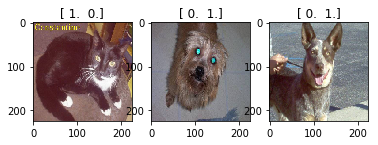

In [9]:
for i in range(1,4):
    plt.subplot(1,3,i)
    plt.imshow(images[i] * 255)
    plt.title(labels[i])

In [10]:
images.shape

(32, 224, 224, 3)

In [11]:
vgg = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
vgg.predict(images)

array([[  3.88169885e-10,   5.39161604e-08,   2.22493157e-09, ...,
          1.37076683e-09,   1.40281804e-06,   3.18108767e-04],
       [  8.28316402e-08,   2.28146490e-07,   4.95612767e-06, ...,
          5.44582912e-09,   4.95767881e-06,   1.62764825e-03],
       [  5.16977856e-08,   1.78457654e-07,   8.45587991e-08, ...,
          8.50160919e-09,   1.22846916e-06,   2.22921221e-06],
       ..., 
       [  7.83055287e-10,   8.41330916e-09,   2.47268248e-11, ...,
          7.48203027e-11,   3.48648643e-09,   2.93821962e-08],
       [  5.53435711e-06,   3.17127433e-06,   1.11146592e-05, ...,
          3.43505803e-07,   9.01114618e-06,   1.38297793e-03],
       [  8.49663895e-09,   4.08782398e-07,   2.42365132e-07, ...,
          1.09585772e-08,   9.09037112e-07,   4.91326265e-02]], dtype=float32)

In [12]:
def get_classes():
    """
        Downloads the Imagenet classes index file and loads it to self.classes.
        The file is downloaded only if it not already in the cache.
    """
    fname = 'imagenet_class_index.json'
    fpath = get_file(fname, 'http://files.fast.ai/models/'+fname, cache_subdir='models')
    with open(fpath) as f:
        class_dict = json.load(f)
    return [class_dict[str(i)][1] for i in range(len(class_dict))]

def get_image_net_classes(all_predictions):
    idxs = np.argmax(all_predictions, axis=1)
    # get the values of the highest probability for each image
    preds = [all_predictions[i, idxs[i]] for i in range(len(idxs))]
    # get the label of the class with the highest probability for each image
    classes = [get_classes()[idx] for idx in idxs]
    return np.array(preds), idxs, classes

In [13]:
get_image_net_classes(vgg.predict(images[0:3]))

(array([ 0.55342996,  0.43115935,  0.31947955], dtype=float32),
 array([157, 284, 252]),
 ['papillon', 'Siamese_cat', 'affenpinscher'])

# Training with bottleneck features

In [14]:
vgg = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')

In [15]:
batch_size = 128

In [16]:
gen = ImageDataGenerator()
train_gen = gen.flow_from_directory(path +  "train", target_size=(224,224), shuffle=False)
valid_gen = gen.flow_from_directory(path +  "valid", target_size=(224,224), shuffle=False)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [17]:
bottleneck_train = vgg.predict_generator(train_gen)
bottleneck_valid = vgg.predict_generator(valid_gen)

In [18]:
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_train)
np.save(open('bottleneck_features_valid.npy', 'wb'), bottleneck_valid)

In [19]:
train_data = np.load(open('bottleneck_features_train.npy', "rb"))
valid_data = np.load(open('bottleneck_features_valid.npy', "rb"))

In [20]:
train_labels = np.array([0] * (train_gen.n // 2) + [1] * (train_gen.n // 2))
valid_labels = np.array([0] * (valid_gen.n // 2) + [1] * (valid_gen.n // 2))

In [42]:
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

top_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = top_model.fit(train_data, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_data=(valid_data, valid_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/50
23000/23000 [==============================] - 2s 96us/step - loss: 5.7578 - acc: 0.6410 - val_loss: 3.3085 - val_acc: 0.7930
Epoch 2/50
23000/23000 [==============================] - 2s 84us/step - loss: 1.3511 - acc: 0.9148 - val_loss: 1.1224 - val_acc: 0.9295
Epoch 3/50
23000/23000 [==============================] - 2s 84us/step - loss: 1.3413 - acc: 0.9157 - val_loss: 0.8371 - val_acc: 0.9475
Epoch 4/50
23000/23000 [==============================] - 2s 84us/step - loss: 1.0069 - acc: 0.9366 - val_loss: 0.9135 - val_acc: 0.9425
Epoch 5/50
23000/23000 [==============================] - 2s 87us/step - loss: 0.8904 - acc: 0.9438 - val_loss: 0.6680 - val_acc: 0.9585
Epoch 6/50
23000/23000 [==============================] - 2s 84us/step - loss: 0.9580 - acc: 0.9396 - val_loss: 0.6339 - val_acc: 0.9605
Epoch 7/50
23000/23000 [==============================] - 2s 85us/step - loss: 0.8093 - acc: 0.9491 - val_loss: 0.7047 - val_acc:

In [43]:
def plot_history(history):
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.subplot(122)
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

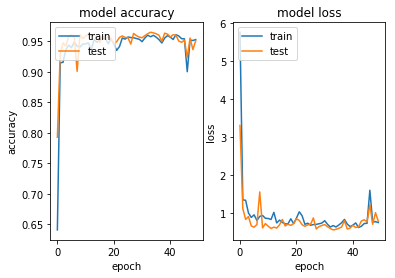

In [44]:
plot_history(history)

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 2s 87us/step - loss: 0.6601 - acc: 0.9588 - val_loss: 0.7186 - val_acc: 0.9550
Epoch 2/10
23000/23000 [==============================] - 2s 87us/step - loss: 0.6522 - acc: 0.9593 - val_loss: 0.7200 - val_acc: 0.9550
Epoch 3/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5999 - acc: 0.9627 - val_loss: 0.6582 - val_acc: 0.9575
Epoch 4/10
23000/23000 [==============================] - 2s 86us/step - loss: 0.5773 - acc: 0.9640 - val_loss: 0.5891 - val_acc: 0.9630
Epoch 5/10
23000/23000 [==============================] - 2s 88us/step - loss: 0.5793 - acc: 0.9638 - val_loss: 0.6261 - val_acc: 0.9610
Epoch 6/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5954 - acc: 0.9629 - val_loss: 0.5937 - val_acc: 0.9630
Epoch 7/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5685 - acc: 0.9645 - val_loss: 0.5793 - val_acc:

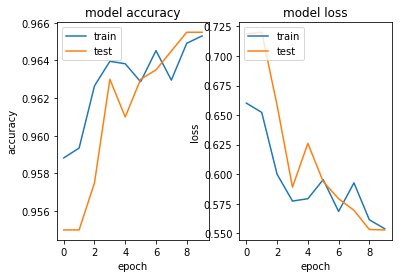

In [45]:
keras.backend.set_value(top_model.optimizer.lr, 0.0001)

history = top_model.fit(train_data, train_labels,
          epochs=10,
          batch_size=batch_size,
          validation_data=(valid_data, valid_labels))

plot_history(history)

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 2s 90us/step - loss: 0.5707 - acc: 0.9643 - val_loss: 0.5774 - val_acc: 0.9640
Epoch 2/10
23000/23000 [==============================] - 2s 87us/step - loss: 0.5564 - acc: 0.9652 - val_loss: 0.5694 - val_acc: 0.9645
Epoch 3/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5534 - acc: 0.9654 - val_loss: 0.5694 - val_acc: 0.9645
Epoch 4/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5518 - acc: 0.9656 - val_loss: 0.5613 - val_acc: 0.9650
Epoch 5/10
23000/23000 [==============================] - 2s 86us/step - loss: 0.5467 - acc: 0.9658 - val_loss: 0.5694 - val_acc: 0.9645
Epoch 6/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5259 - acc: 0.9670 - val_loss: 0.5612 - val_acc: 0.9650
Epoch 7/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5573 - acc: 0.9651 - val_loss: 0.5208 - val_acc:

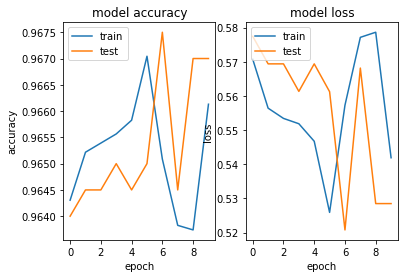

In [46]:
keras.backend.set_value(top_model.optimizer.lr, 0.0001)

history = top_model.fit(train_data, train_labels,
          epochs=10,
          batch_size=batch_size,
          validation_data=(valid_data, valid_labels))

plot_history(history)

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 2s 86us/step - loss: 0.5631 - acc: 0.9648 - val_loss: 0.5285 - val_acc: 0.9670
Epoch 2/10
23000/23000 [==============================] - 2s 88us/step - loss: 0.5457 - acc: 0.9658 - val_loss: 0.5285 - val_acc: 0.9670
Epoch 3/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5393 - acc: 0.9662 - val_loss: 0.5285 - val_acc: 0.9670
Epoch 4/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5520 - acc: 0.9655 - val_loss: 0.5285 - val_acc: 0.9670
Epoch 5/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5480 - acc: 0.9657 - val_loss: 0.5285 - val_acc: 0.9670
Epoch 6/10
23000/23000 [==============================] - 2s 86us/step - loss: 0.5595 - acc: 0.9650 - val_loss: 0.5285 - val_acc: 0.9670
Epoch 7/10
23000/23000 [==============================] - 2s 88us/step - loss: 0.5571 - acc: 0.9651 - val_loss: 0.5285 - val_acc:

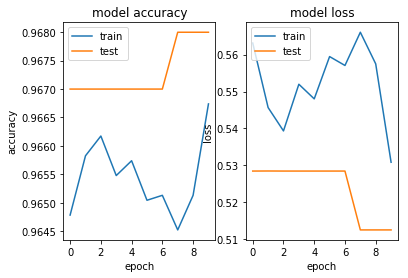

In [47]:
keras.backend.set_value(top_model.optimizer.lr, 0.00001)

history = top_model.fit(train_data, train_labels,
          epochs=10,
          batch_size=batch_size,
          validation_data=(valid_data, valid_labels))

plot_history(history)

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 2s 90us/step - loss: 0.5568 - acc: 0.9652 - val_loss: 0.5125 - val_acc: 0.9680
Epoch 2/10
23000/23000 [==============================] - 2s 86us/step - loss: 0.5553 - acc: 0.9653 - val_loss: 0.5125 - val_acc: 0.9680
Epoch 3/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5574 - acc: 0.9651 - val_loss: 0.5125 - val_acc: 0.9680
Epoch 4/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5576 - acc: 0.9650 - val_loss: 0.5125 - val_acc: 0.9680
Epoch 5/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5559 - acc: 0.9652 - val_loss: 0.5125 - val_acc: 0.9680
Epoch 6/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5320 - acc: 0.9667 - val_loss: 0.5125 - val_acc: 0.9680
Epoch 7/10
23000/23000 [==============================] - 2s 85us/step - loss: 0.5540 - acc: 0.9653 - val_loss: 0.5125 - val_acc:

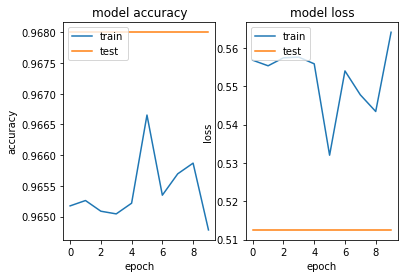

In [48]:
keras.backend.set_value(top_model.optimizer.lr, 0.000001)

history = top_model.fit(train_data, train_labels,
          epochs=10,
          batch_size=batch_size,
          validation_data=(valid_data, valid_labels))

plot_history(history)

# Finteuning the top conv layer

In [49]:
vgg = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
new_model = Sequential()

for layer in vgg.layers:
    new_model.add(layer)

for layer in top_model.layers:
    new_model.add(layer)

In [50]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [51]:
new_model.layers[:-8]

In [52]:
for layer in new_model.layers[:-8]:
    layer.trainable = False

In [53]:
#new_model.save_weights("new_model_weights")

In [60]:
new_model.load_weights("new_model_weights")

In [61]:
batch_size = 64

new_model.compile(optimizer= optimizers.SGD(lr= 0.00001, momentum = 0.05),
              loss='binary_crossentropy',
              metrics=['accuracy'])

aug_gen = ImageDataGenerator(#rotation_range=30,
                             #   width_shift_range=0.1,
                             #   height_shift_range=0.1,
                             #   vertical_flip=True,
                             #   zoom_range=0.1
                            )

gen = ImageDataGenerator()

train_gen = aug_gen.flow_from_directory(path +  "train", target_size=(224,224), shuffle=True, class_mode="binary", batch_size = batch_size)
valid_gen = gen.flow_from_directory(path +  "valid", target_size=(224,224), shuffle=True, class_mode="binary", batch_size = batch_size)

history = new_model.fit_generator(train_gen,
                                  steps_per_epoch = train_gen.n // batch_size, 
                                  epochs=10,
                                  validation_data=valid_gen)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10
359/359 [==============================] - 117s 325ms/step - loss: 0.6118 - acc: 0.9617 - val_loss: 0.7156 - val_acc: 0.9555
Epoch 2/10
359/359 [==============================] - 116s 322ms/step - loss: 0.6128 - acc: 0.9617 - val_loss: 0.5977 - val_acc: 0.9625
Epoch 3/10
359/359 [==============================] - 115s 321ms/step - loss: 0.5899 - acc: 0.9631 - val_loss: 0.5684 - val_acc: 0.9645
Epoch 4/10
359/359 [==============================] - 115s 320ms/step - loss: 0.7725 - acc: 0.9516 - val_loss: 0.5443 - val_acc: 0.9660
Epoch 5/10
359/359 [==============================] - 115s 320ms/step - loss: 0.7562 - acc: 0.9526 - val_loss: 0.5603 - val_acc: 0.9650
Epoch 6/10
359/359 [==============================] - 115s 321ms/step - loss: 0.7516 - acc: 0.9530 - val_loss: 1.4619 - val_acc: 0.9085
Epoch 7/10
359/359 [==============================] - 116s 322ms/step - loss: 0.6167 - acc: 0.9613 

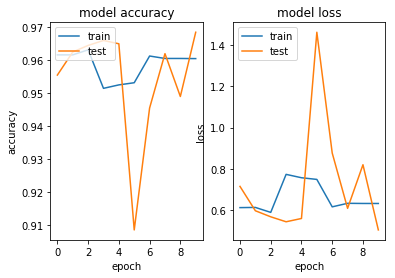

In [62]:
plot_history(history)

# Creating kaggle output

In [ ]:
test_gen = gen.flow_from_directory(path +  "test", class_mode=None, target_size=(224,224), shuffle=False)

In [ ]:
bottleneck_test = vgg.predict_generator(test_gen)

In [ ]:
pred = model.predict(bottleneck_test, verbose=1)

In [ ]:
pred

In [ ]:
filenames = test_gen.filenames

In [ ]:
df = pd.DataFrame(filenames, columns=["id"])
df["label"] = (pred)

In [ ]:
df

In [ ]:
df["label"] = df["label"].astype(int)

In [ ]:
df["id"] = df["id"].replace(["test1/", ".jpg"], ["", ""], regex=True)

In [ ]:
df

In [ ]:
df.to_csv("bottlenack_pred.csv", sep=",", index=False)